In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

# Define the maze layout
maze_layout = np.array([
[0, 0, 1, 0, 1],
[1, 0, 0, 0, 0],
[0, 0, 1, 0, 1],
[1, 0, 1, 0, 0],
[1, 0, 0, 1, 0]

])

# Define the Maze class
class Maze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position

    def show_maze(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
        plt.xticks([]), plt.yticks([])
        plt.show()

# Define the DQN neural network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Increase hidden layer size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the DQN agent
class DQNAgent:
    def __init__(self, maze, input_dim, output_dim, learning_rate=0.001, discount_factor=0.99, exploration_start=1.0, exploration_end=0.01, exploration_decay=0.995, batch_size=64, memory_size=10000):
        self.maze = maze
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_start
        self.exploration_end = exploration_end
        self.exploration_decay = exploration_decay
        self.batch_size = batch_size

        # Neural networks
        self.policy_net = DQN(input_dim, output_dim)
        self.target_net = DQN(input_dim, output_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        # Experience replay buffer
        self.memory = deque(maxlen=memory_size)

    def get_state(self, position):
        return torch.FloatTensor([position[0], position[1]])

    def get_action(self, state):
        if random.random() < self.exploration_rate:
            return random.randint(0, self.output_dim - 1)  # Random action
        else:
            with torch.no_grad():
                return self.policy_net(state).argmax().item()  # Greedy action

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.stack(states)
        actions = torch.tensor(actions)
        rewards = torch.tensor(rewards)
        next_states = torch.stack(next_states)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Double DQN: Use policy network to select actions, target network to evaluate
        next_actions = self.policy_net(next_states).argmax(1)
        next_q_values = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        target_q_values = rewards + (1 - dones) * self.discount_factor * next_q_values

        # Compute loss and update the policy network
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        loss = self.loss_fn(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay exploration rate
        self.exploration_rate = max(self.exploration_end, self.exploration_rate * self.exploration_decay)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Define the reward system
goal_reward = 500
wall_penalty = -10
step_penalty = -1

# Define the finish_episode function
def finish_episode(agent, maze, current_episode, train=True):
    current_state = agent.get_state(maze.start_position)
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [maze.start_position]
    max_steps = 100  # Maximum allowed steps per episode

    while not is_done:
        action = agent.get_action(current_state)
        next_state = (int(current_state[0].item() + actions[action][0]), int(current_state[1].item() + actions[action][1]))

        # Check for invalid moves
        if next_state in path:  # Penalize revisiting the same state
            reward = -2
        elif next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width or maze.maze[next_state[1]][next_state[0]] == 1:
            reward = wall_penalty
            next_state = (int(current_state[0].item()), int(current_state[1].item()))  # Stay in the same state
        elif next_state == maze.goal_position:
            reward = goal_reward
            is_done = True
        else:
            reward = step_penalty

        # Penalize long episodes
        if episode_step >= max_steps:
            reward = -100  # Penalty for taking too long
            is_done = True

        episode_reward += reward
        episode_step += 1
        path.append((int(current_state[0].item()), int(current_state[1].item())))

        # Convert next_state to tensor
        next_state_tensor = agent.get_state(next_state)

        if train:
            agent.remember(current_state, action, reward, next_state_tensor, is_done)
            agent.replay()

        current_state = next_state_tensor

    if train and current_episode % 10 == 0:
        agent.update_target_network()

    return episode_reward, episode_step, path

# Define the test_agent function
def test_agent(agent, maze):
    episode_reward, episode_step, path = finish_episode(agent, maze, 0, train=False)

    print("Learned Path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("Goal!")

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    plt.figure(figsize=(5, 5))
    plt.imshow(maze.maze, cmap='gray')
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)
    for position in path:
        plt.text(position[0], position[1], "#", va='center', color='blue', fontsize=20)
    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.show()

# Define the train_agent function
def train_agent(agent, maze, num_episodes=100):
    episode_rewards = []
    episode_steps = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path = finish_episode(agent, maze, episode, train=True)
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)

        # Print progress
        print(f"Episode: {episode + 1}, Reward: {episode_reward}, Steps: {episode_step}, Exploration Rate: {agent.exploration_rate:.4f}")

        # Early stopping if the agent consistently reaches the goal
        if episode_reward >= goal_reward - 10:  # Close to the goal reward
            print("Agent has learned the maze! Stopping training.")
            break

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward per Episode')

    plt.subplot(1, 2, 2)
    plt.plot(episode_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.title('Steps per Episode')

    plt.tight_layout()
    plt.show()

# Initialize the maze and agent
maze = Maze(maze_layout, (0, 0), (4, 4))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

input_dim = 2  # (x, y) position
output_dim = 4  # 4 actions
agent = DQNAgent(
    maze,
    input_dim,
    output_dim,
    learning_rate=0.0005,
    discount_factor=0.99,
    exploration_start=1.0,  # Start with full exploration
    exploration_end=0.01,
    exploration_decay=0.999,  # Slower decay
    batch_size=128,
    memory_size=20000
)

import seaborn as sns

def visualize_q_values(agent, maze):
    # Create a grid to store Q-values for each state-action pair
    q_values_grid = np.zeros((maze.maze_height, maze.maze_width, 4))  # 4 actions: Up, Down, Left, Right

    # Loop through all states in the maze
    for x in range(maze.maze_height):
        for y in range(maze.maze_width):
            if maze.maze[y][x] == 1:  # Skip walls
                continue
            state = agent.get_state((x, y))
            with torch.no_grad():
                q_values = agent.policy_net(state).numpy()  # Get Q-values for all actions
            q_values_grid[x][y] = q_values

    # Plot Q-values for each action
    action_names = ["Up", "Down", "Left", "Right"]
    plt.figure(figsize=(15, 10))
    for i, action in enumerate(action_names):
        plt.subplot(2, 2, i + 1)
        sns.heatmap(q_values_grid[:, :, i], annot=True, fmt=".2f", cmap="viridis", cbar=False)
        plt.title(f"Q-values for Action: {action}")
        plt.xlabel("X")
        plt.ylabel("Y")
    plt.tight_layout()
    plt.show()


def visualize_state_values(agent, maze):
    # Create a grid to store state values
    state_values = np.zeros((maze.maze_height, maze.maze_width))

    # Loop through all states in the maze
    for x in range(maze.maze_height):
        for y in range(maze.maze_width):
            if maze.maze[y][x] == 1:  # Skip walls
                state_values[x][y] = np.nan  # Mark walls as NaN
                continue
            state = agent.get_state((x, y))
            with torch.no_grad():
                q_values = agent.policy_net(state).numpy()  # Get Q-values for all actions
            state_values[x][y] = np.max(q_values)  # State value is the max Q-value

    # Plot state values
    plt.figure(figsize=(5, 5))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap="viridis", cbar=True, mask=np.isnan(state_values))
    plt.title("State Values")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def visualize_policy(agent, maze):
    # Create a grid to store the policy
    policy_grid = np.zeros((maze.maze_height, maze.maze_width), dtype=str)

    # Define action symbols
    action_symbols = ["↑", "↓", "←", "→"]  # Up, Down, Left, Right

    # Loop through all states in the maze
    for x in range(maze.maze_height):
        for y in range(maze.maze_width):
            if maze.maze[y][x] == 1:  # Skip walls
                policy_grid[x][y] = "■"  # Mark walls
                continue
            state = agent.get_state((x, y))
            with torch.no_grad():
                q_values = agent.policy_net(state).numpy()  # Get Q-values for all actions
            best_action = np.argmax(q_values)  # Select the action with the highest Q-value
            policy_grid[x][y] = action_symbols[best_action]

    # Plot policy
    plt.figure(figsize=(5, 5))
    sns.heatmap(np.zeros_like(policy_grid, dtype=float), annot=policy_grid, fmt="", cmap="viridis", cbar=False)
    plt.title("Policy (Best Action for Each State)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

    # Plot policy
    plt.figure(figsize=(5, 5))
    sns.heatmap(np.zeros_like(policy_grid, dtype=float), annot=policy_grid, fmt="", cmap="viridis", cbar=False)
    plt.title("Policy (Best Action for Each State)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()




In [2]:
import matplotlib.animation as animation
import matplotlib.patches as patches

def animate_maze_solution(agent, maze, path=None, interval=500):
    """
    Animate the agent's path through the maze.

    Parameters:
    - agent: The DQN agent
    - maze: The maze environment
    - path: Pre-computed path (if None, will run the agent to get a path)
    - interval: Time between frames in milliseconds
    """
    if path is None:
        _, _, path = finish_episode(agent, maze, 0, train=False)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 7))

    # Draw the maze
    ax.imshow(maze.maze, cmap='gray')
    ax.text(maze.start_position[0], maze.start_position[1], 'S',
            ha='center', va='center', color='red', fontsize=20)
    ax.text(maze.goal_position[0], maze.goal_position[1], 'G',
            ha='center', va='center', color='green', fontsize=20)
    ax.grid(color='black', linewidth=2)

    # Create a circle to represent the agent
    agent_circle = patches.Circle((path[0][0], path[0][1]),
                                  radius=0.3, fc='blue', ec='black', zorder=10)
    ax.add_patch(agent_circle)

    # Keep track of visited positions
    visited = set()
    visited_markers = []

    # Initialize text for step counter
    step_text = ax.text(0.05, 0.95, 'Step: 0', transform=ax.transAxes,
                        fontsize=12, verticalalignment='top')

    def init():
        agent_circle.center = (path[0][0], path[0][1])
        for marker in visited_markers:
            marker.remove()
        visited_markers.clear()
        visited.clear()
        step_text.set_text('Step: 0')
        return [agent_circle, step_text]

    def update(frame):
        # Update agent position
        x, y = path[frame]
        agent_circle.center = (x, y)

        # Mark visited positions with footprint
        if (x, y) not in visited and (x, y) != path[0]:
            visited.add((x, y))
            footprint = ax.text(x, y, '•', ha='center', va='center',
                               color='blue', fontsize=15, alpha=0.7)
            visited_markers.append(footprint)

        # Update step counter
        step_text.set_text(f'Step: {frame}')

        return [agent_circle, step_text] + visited_markers

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(path),
                                  init_func=init, blit=True, interval=interval)

    plt.close()  # Prevent duplicate display
    return anim, fig

# Example of how to use it
def visualize_agent_journey():
    # Train agent if not already trained
    # train_agent(agent, maze, num_episodes=100)

    # Get the agent's path
    _, _, path = finish_episode(agent, maze, 0, train=False)

    # Create and display the animation
    anim, fig = animate_maze_solution(agent, maze, path, interval=500)

    # Display the animation in a notebook
    from IPython.display import HTML
    HTML(anim.to_jshtml())

    # To save the animation (optional)
    # anim.save('maze_solution.gif', writer='pillow', fps=2)

    # Show the figure with the animation
    plt.figure(fig.number)
    plt.show()

# For a more advanced animation with agent direction
def animate_maze_solution_with_direction(agent, maze, path=None, interval=500):
    """
    Animate the agent's path through the maze with direction indicators.
    """
    if path is None:
        _, _, path = finish_episode(agent, maze, 0, train=False)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 7))

    # Draw the maze
    ax.imshow(maze.maze, cmap='gray')
    ax.text(maze.start_position[0], maze.start_position[1], 'S',
            ha='center', va='center', color='red', fontsize=20)
    ax.text(maze.goal_position[0], maze.goal_position[1], 'G',
            ha='center', va='center', color='green', fontsize=20)
    ax.grid(color='black', linewidth=2)

    # Create a triangle to represent the agent with direction
    agent_marker = patches.RegularPolygon((path[0][0], path[0][1]), 3,
                                         radius=0.4, orientation=0,
                                         fc='blue', ec='black', zorder=10)
    ax.add_patch(agent_marker)

    # Path line
    path_line, = ax.plot([], [], 'blue', alpha=0.5, linewidth=2)

    # Keep track of visited positions
    visited_x = []
    visited_y = []

    # Initialize text for step counter and reward
    info_text = ax.text(0.05, 0.95, 'Step: 0', transform=ax.transAxes,
                      fontsize=12, verticalalignment='top')

    def init():
        agent_marker.xy = (path[0][0], path[0][1])
        path_line.set_data([], [])
        visited_x.clear()
        visited_y.clear()
        info_text.set_text('Step: 0')
        return [agent_marker, path_line, info_text]

    def update(frame):
        # Get current and previous positions
        x, y = path[frame]

        # Add position to visited list
        visited_x.append(x)
        visited_y.append(y)
        path_line.set_data(visited_x, visited_y)

        # Update agent position
        agent_marker.xy = (x, y)

        # Calculate orientation (direction) if not at the first frame
        if frame > 0:
            prev_x, prev_y = path[frame-1]
            dx = x - prev_x
            dy = y - prev_y

            # Set orientation based on movement direction
            if dx == 1 and dy == 0:  # Right
                agent_marker.orientation = 0  # 0 radians
            elif dx == -1 and dy == 0:  # Left
                agent_marker.orientation = np.pi  # 180 degrees
            elif dx == 0 and dy == 1:  # Down
                agent_marker.orientation = np.pi/2  # 90 degrees
            elif dx == 0 and dy == -1:  # Up
                agent_marker.orientation = 3*np.pi/2  # 270 degrees

        # Update info text
        info_text.set_text(f'Step: {frame}')

        return [agent_marker, path_line, info_text]

    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=len(path),
                                  init_func=init, blit=True, interval=interval)

    plt.close()  # Prevent duplicate display
    return anim, fig

# Function to show the animation in the notebook
def display_animation_in_notebook(anim):
    from IPython.display import HTML
    return HTML(anim.to_jshtml())

# Example usage
# anim, fig = animate_maze_solution_with_direction(agent, maze)
# display_animation_in_notebook(anim)

Learned Path:
(0, 0)-> (0, 0)-> (1, 0)-> (1, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (1, 0)-> (0, 0)-> (1, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (1, 0)-> (1, 0)-> (1, 0)-> (1, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (1, 0)-> (1, 1)-> (1, 2)-> (1, 2)-> (1, 2)-> (1, 3)-> (1, 3)-> (1, 4)-> (1, 4)-> (1, 4)-> (1, 4)-> (1, 4)-> (1, 4)-> (2, 4)-> (2, 4)-> (2, 4)-> (1, 4)-> (1, 3)-> (1, 4)-> (1, 3)-> (1, 3)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 1)-> (1, 0)-> (1, 1)-> (1, 1)-> (1, 0)-> (0, 0)-> (1, 0)-> (1, 1)-> (2, 1)-> (1, 1)-> (1, 1)-> (2, 1)-> (1, 1)-> (1, 1)-> (1, 0)-> (1, 1)-> (1, 1)-> (1, 0)-> (1, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (0, 0)-> (1, 0)-> (1, 0)-> (1, 0)-> (1, 1)-> (2, 1)-> (2, 1)-> (3, 1)-> (4, 1)-> (4, 1)-> (4, 1)-> (4, 1)-> (4, 1)-> (3, 1)-> (2, 1)-> (2, 1)-> (1, 1)-> (1, 1)-> (1, 0)-> (1, 0)-> (1, 0)-> (1, 1)-> (1, 2)-> (1, 1)-> (1, 0)-> (0, 0)-> (0, 0)-> Goal!
Number of steps: 101
Total reward: -707


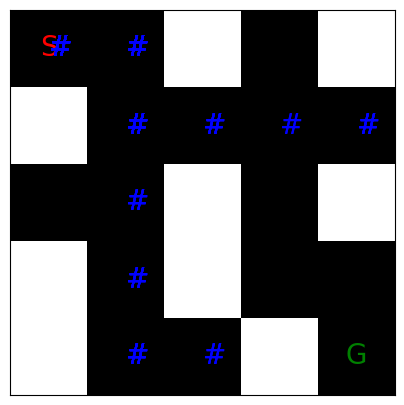

In [9]:
# Test the agent before
test_agent(agent, maze)

In [10]:
# For basic animation
anim, fig = animate_maze_solution(agent, maze)
plt.show()
# OR for the directional animation
anim, fig = animate_maze_solution_with_direction(agent, maze)
plt.show()

In [11]:
from IPython.display import HTML
HTML(anim.to_jshtml())

In [13]:
anim.save("output.gif", writer="pillow")
from google.colab import files
files.download("output.gif")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Episode: 1, Reward: -732, Steps: 101, Exploration Rate: 1.0000
Episode: 2, Reward: -717, Steps: 101, Exploration Rate: 0.9277
Episode: 3, Reward: 127, Steps: 61, Exploration Rate: 0.8728
Episode: 4, Reward: -785, Steps: 101, Exploration Rate: 0.7889
Episode: 5, Reward: -541, Steps: 101, Exploration Rate: 0.7131
Episode: 6, Reward: -605, Steps: 101, Exploration Rate: 0.6445
Episode: 7, Reward: 65, Steps: 80, Exploration Rate: 0.5950
Episode: 8, Reward: -534, Steps: 101, Exploration Rate: 0.5378
Episode: 9, Reward: -725, Steps: 101, Exploration Rate: 0.4861
Episode: 10, Reward: -798, Steps: 101, Exploration Rate: 0.4394
Episode: 11, Reward: -566, Steps: 101, Exploration Rate: 0.3971
Episode: 12, Reward: -469, Steps: 101, Exploration Rate: 0.3590
Episode: 13, Reward: -548, Steps: 101, Exploration Rate: 0.3245
Episode: 14, Reward: 45, Steps: 90, Exploration Rate: 0.2965
Episode: 15, Reward: 285, Steps: 56, Exploration Rate: 0.2804
Episode: 16, Reward: -193, Steps: 91, Exploration Rate: 0.2

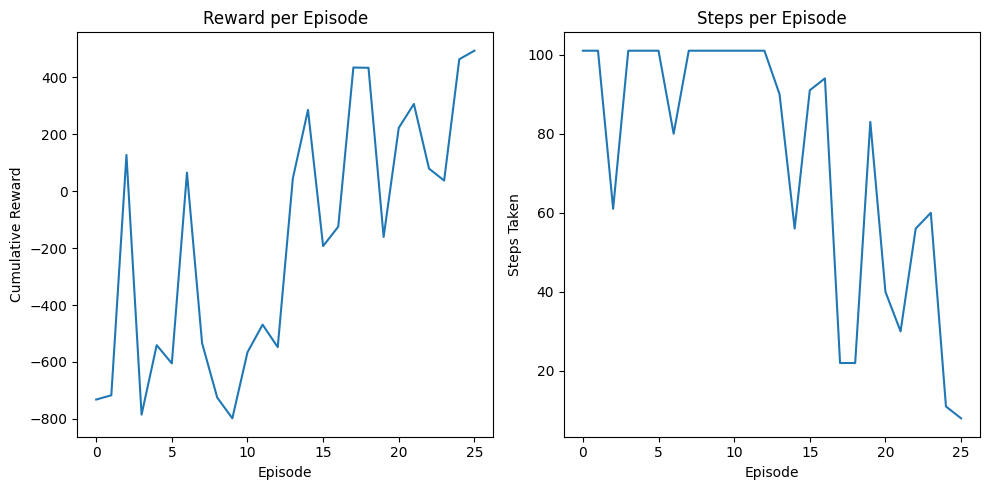

In [14]:
# Train the agent
train_agent(agent, maze, num_episodes=100)


Learned Path:
(0, 0)-> (0, 0)-> (1, 0)-> (1, 1)-> (2, 1)-> (3, 1)-> (3, 2)-> (3, 3)-> (4, 3)-> Goal!
Number of steps: 8
Total reward: 493


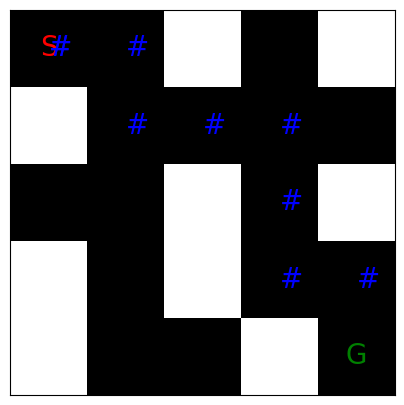

In [16]:

# Test the agent
test_agent(agent, maze)

In [19]:
# For basic animation
anim, fig = animate_maze_solution(agent, maze)
plt.show()
# OR for the directional animation
anim, fig = animate_maze_solution_with_direction(agent, maze)
plt.show()



In [20]:
from IPython.display import HTML
HTML(anim.to_jshtml())

In [22]:
anim.save("output.gif", writer="pillow")
from google.colab import files
files.download("output.gif")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

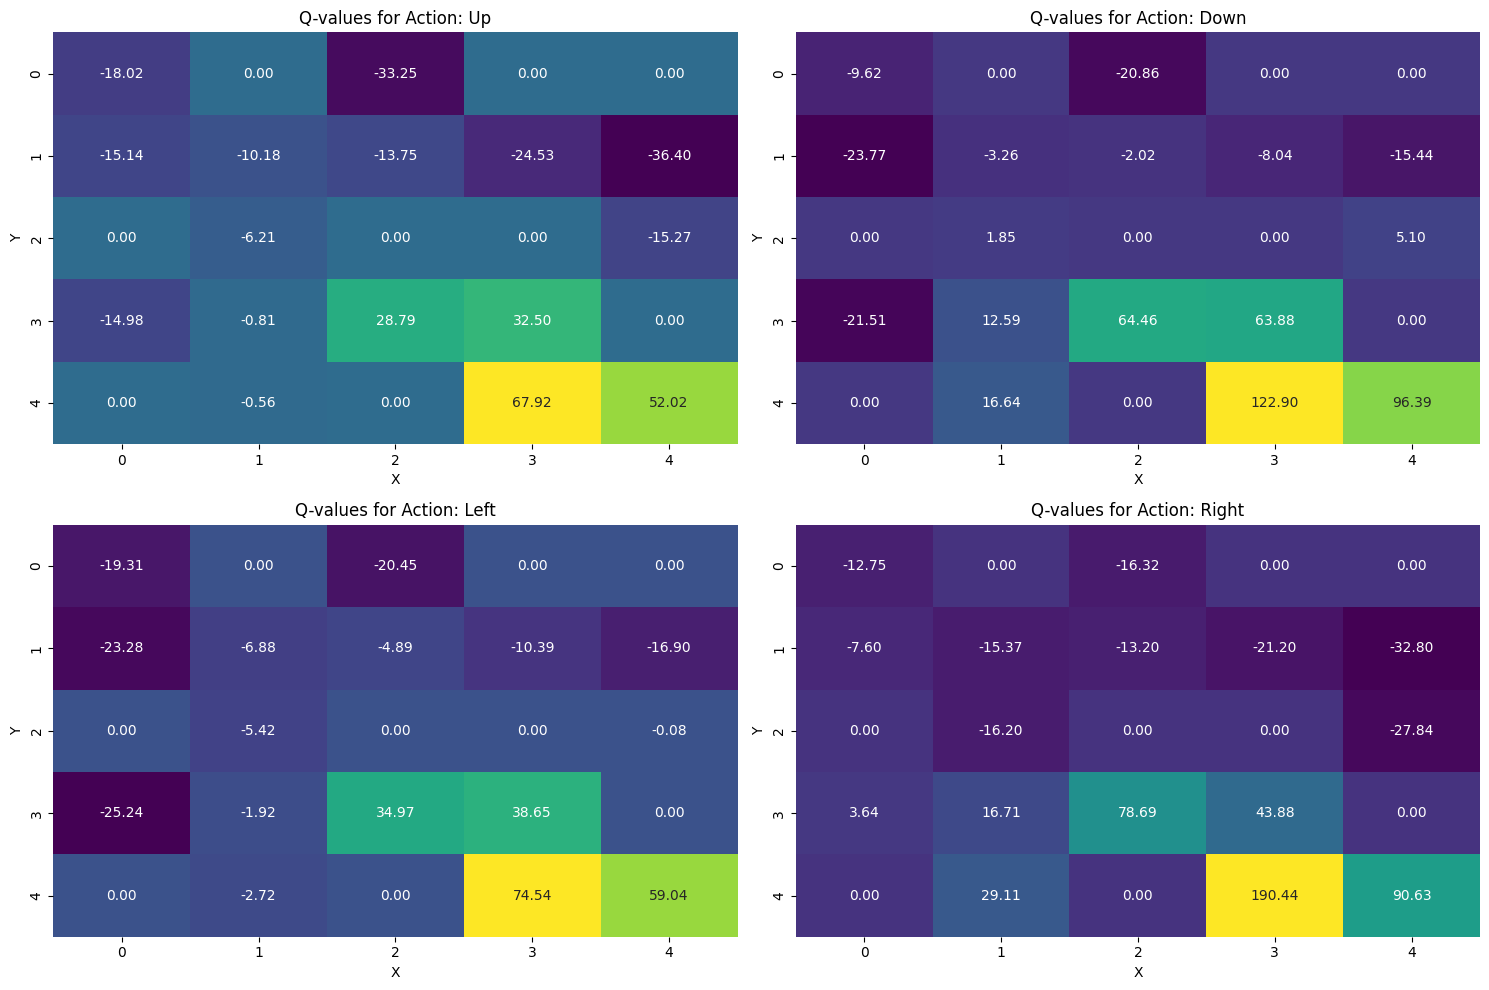

In [23]:
# Visualize Q-values
visualize_q_values(agent, maze)

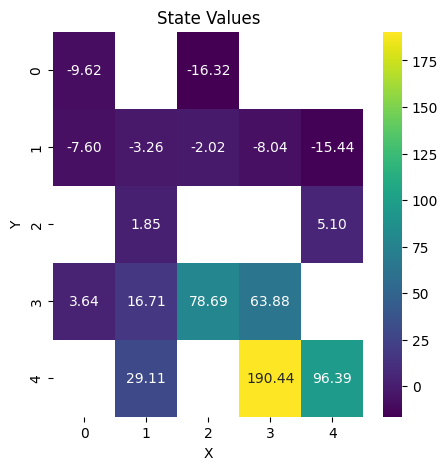

In [24]:
# Visualize state values
visualize_state_values(agent, maze)

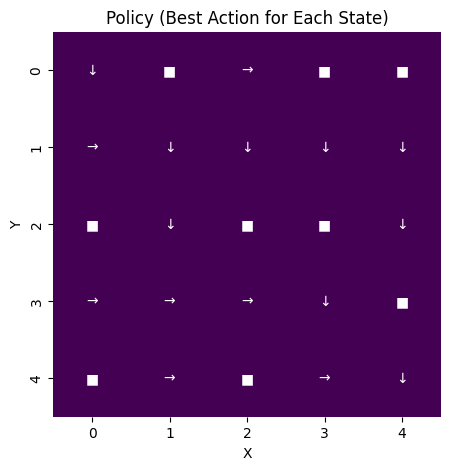

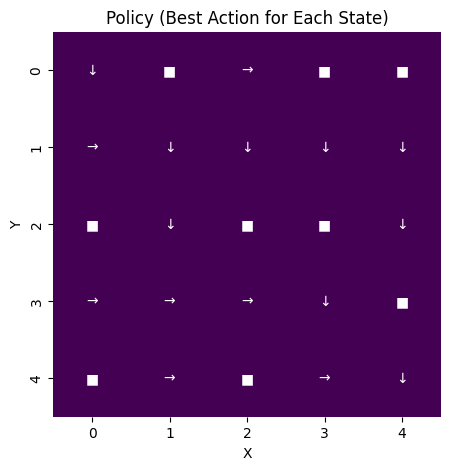

In [25]:

# Visualize policy
visualize_policy(agent, maze)